In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
import numpy as np
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
if use_cuda: 
    torch.cuda.empty_cache()

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.1307,), (0.3081,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=40,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=40,
                                         shuffle=False, num_workers=2)


classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


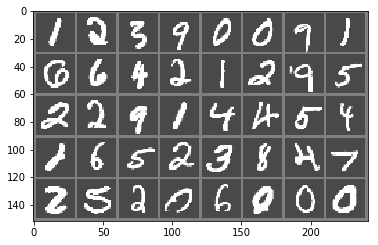

    1     2     3     9


In [7]:

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def imshow2(img): 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Make model
Define CNN 

In [18]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

torch.manual_seed(42)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(10, 20, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(20, 20, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.fc1 = nn.Linear(20 * 7 * 7, 500)
        self.fc2 = nn.Linear(500, 250)
        
        self.fc31 = nn.Linear(250, 50)
        self.fc32 = nn.Linear(250, 50)
        
    def forward(self, x):
        # start 1 x 28 x 28
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x, pool_indices_1 = self.pool(x)
        # now 10 x 14 x 14
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x, pool_indices_2 = self.pool(x)
        # now 20 x 7 x 7)
        
        x = x.view(-1, 20 * 7 * 7)
        x = F.relu(self.fc1(x))
        # now 1 x 500
        
        x = F.relu(self.fc2(x))
        # now 1 x 250 
        
        # Split into means and std deviations
        mu = self.fc31(x)
        logvar = self.fc32(x)
        # now 2 * 1 x 50 
        
        return mu, logvar, pool_indices_1, pool_indices_2

class Decoder(nn.Module): 
    def __init__(self): 
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(50, 250)
        self.fc2 = nn.Linear(250, 500)
        self.fc3 = nn.Linear(500, 20 * 7 * 7)
        self.conv1 = nn.ConvTranspose2d(20, 20, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.ConvTranspose2d(20, 10, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.ConvTranspose2d(10, 10, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.ConvTranspose2d(10, 1, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxUnpool2d(2, 2)
        self.sigmoid = nn.Sigmoid()
        
        self.pool_indices_1 = self.make_top_left_unpool_indices((40, 10, 14, 14)).type(torch.LongTensor).to(device)
        self.pool_indices_2 = self.make_top_left_unpool_indices((40, 20, 7, 7)).type(torch.LongTensor).to(device)
        
    @staticmethod
    def make_top_left_unpool_indices(shape, stride=(2, 2)):
        """
        Create an unpooling index that always puts the value in the top left of the 
        unpooling kernel.
        """
        out = np.zeros(shape) # TODO 
        for b in range(shape[0]): 
            for d in range(shape[1]): 
                for x in range(shape[2]): 
                    for y in range(shape[3]):
                        out[b, d, x, y] = x * shape[3] * 2 * stride[0] + y * stride[1]
        return torch.from_numpy(out).float()
    
    def forward(self, x): 
        # start 50
        
        x = self.fc1(x)
        # now 250
        
        x = F.relu(self.fc2(x))
        # now 500
        
        x = F.relu(self.fc3(x))
        # now 20 * 7 * 7
        
        x = x.view(-1, 20, 7, 7)
        # now 20 x 7 x 7
        
        x = self.pool(x, self.pool_indices_2)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # now 10 x 14 x 14
        
        x = self.pool(x, self.pool_indices_1)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        # now 1 x 28 x 28
        
        # normalize to range -1 to 1 to match input data
        x = self.sigmoid(x)
        x = (x - .75) * 4
        
        return x
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparametrize(self, mu, logvar, deviation=1.):
        if not isinstance(deviation, torch.Tensor):
            deviation = torch.FloatTensor([deviation]).repeat(50).to(device)
            
        std = logvar.mul(0.5).exp_() * deviation
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        
        # cleanup
        if isinstance(deviation, torch.Tensor):
            deviation.detach()
            
        return eps.mul(std).add_(mu)
    
    def encode(self, x): 
        mu, logvar, _, _ = self.encoder(x)
        return mu, logvar
    
    def decode(self, x): 
        return self.decoder(x)
    
    def sample(self, mu, logvar, deviation=1.): 
        z = self.reparametrize(mu.to(device), logvar.to(device), deviation)
        z = z.to(device)
        decoded = self.decode(z)
        return decoded.cpu().detach()
    
    def forward(self, x):
        # encode
        mu, logvar, _, _ = self.encoder(x)
        
        # sample
        z = self.reparametrize(mu, logvar)
        
        result = self.decode(z)
        return result, mu, logvar
    
net = Net().to(device)

loss function


In [5]:
reconstruction_function = nn.MSELoss(size_average=False)

def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    BCE = reconstruction_function(recon_x, x)  # mse loss
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return BCE + KLD

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [6]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001,
                             weight_decay=1e-5)

training procedure

In [7]:
from datetime import datetime

def train():
    last_print = datetime.now()

    for epoch in range(4):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, _ = data
            inputs = inputs.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)

            recon_batch, mu, logvar = net(inputs)
            loss = loss_function(recon_batch, inputs, mu, logvar)
            loss.backward()

            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 500 == 499:    # print every 49 mini-batches
                now = datetime.now()
                elapsed = now - last_print
                last_print = now

                print('[%d, %5d] loss: %.3f elapsed seconds: %.3f' %
                      (epoch + 1, i + 1, running_loss / 500, elapsed.total_seconds()))
                running_loss = 0.0

    print('Finished Training')

In [19]:
vae_weights_path = "model/vae_weight.pt"
try: 
    net.load_state_dict(torch.load(vae_weights_path))
    net.eval()
except:
    train()
    torch.save(net.state_dict(), vae_weights_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[ 0.0426, -0.0491, -0.0246,  ..., -0.0322,  0.0748, -0.0223],
        [-0.1253, -0.1643,  0.0284,  ...,  0.0873,  0.0461, -0.1128],
        [ 0.0353,  0.0196, -0.0215,  ..., -0.0319, -0.0035, -0.0186],
        ...,
        [ 0.0227, -0.0235,  0.0318,  ..., -0.0148, -0.0007,  0.0046],
        [-0.0754,  0.0156, -0.0008,  ...,  0.0688, -0.0142, -0.0624],
        [ 0.0487, -0.0056,  0.0520,  ..., -0.0141,  0.0519, -0.0438]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0386, -0.0481,  0.0014,  ..., -0.0357,  0.0591,  0.0332],
        [ 0.0630, -0.0065,  0.1078,  ..., -0.0492,  0.0299, -0.0463],
        [ 0.0019, -0.0326, -0.0050,  ..., -0.0378, -0.0521, -0.0065],
        ...,
        [-0.0434, -0.0408, -0.0173,  ..., -0.0190, -0.0090,  0.0058],
        [ 0.0635, -0.0303, -0.0144,  ..., -0.0935,  0.0173, -0.0138],
        [ 0.0089, -0.0076, -0.0096,  ..., -0.0393,  0.0021, -0.0177]],
       device='cuda:0', grad_fn=<AddmmBackward>)
torch.Size([40, 50])
torch.Size([4

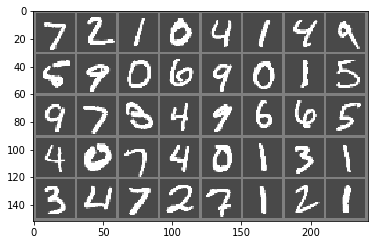

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PREDICTED / GENERATED:


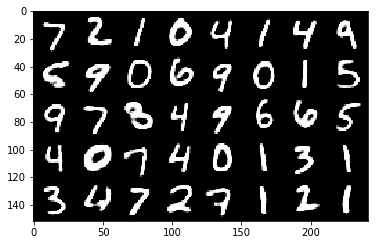

In [64]:
dataiter = iter(testloader)
images, labels = dataiter.next()
outputs, mu, logvar = net(images.to(device))
outputs = outputs.to("cpu").detach()

print(mu)
print(logvar)
print(mu.shape)
print(logvar.shape)

print("ACTUAL:")
imshow(torchvision.utils.make_grid(images))

print("PREDICTED / GENERATED:") 
imshow2(torchvision.utils.make_grid(outputs))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ACTUAL:


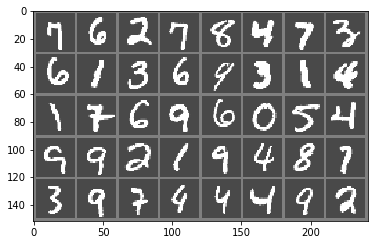

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([40, 50])
tensor([[ 0.6151, -2.4429, -0.3259,  ..., -1.6006,  0.0938,  0.3311],
        [-0.6088,  0.0789,  0.7318,  ..., -0.4748,  0.1998, -0.1451],
        [ 0.6920,  1.0241, -1.5040,  ...,  0.1919, -0.4501,  0.7106],
        ...,
        [ 0.8026,  1.1802,  1.2123,  ..., -0.0494,  1.8772, -0.2471],
        [-0.2213,  0.4573, -2.0008,  ..., -1.8065, -0.1923,  1.1726],
        [ 2.4777, -0.2550,  0.0881,  ..., -1.9037,  0.7725, -3.6520]],
       device='cuda:0', grad_fn=<AddBackward0>)
PREDICTED / GENERATED:
torch.Size([40, 1, 28, 28])


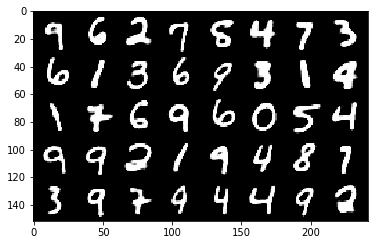

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([40, 50])
tensor([[-0.3841, -0.5159, -0.1670,  ...,  0.4698,  1.1221, -0.6654],
        [ 0.0515, -0.2305,  1.2212,  ...,  1.3607,  0.4456, -0.5101],
        [-0.6565,  1.0375, -1.3181,  ..., -0.1940,  2.1063, -0.5990],
        ...,
        [-2.3770,  1.1075, -0.7308,  ..., -0.0904,  1.0112,  0.3599],
        [-1.0661,  0.5892, -0.6109,  ..., -0.3522, -0.4603, -1.3376],
        [ 1.9934, -0.0177,  0.6162,  ...,  1.1922, -0.5996,  0.2678]],
       device='cuda:0', grad_fn=<AddBackward0>)
PREDICTED / GENERATED:
torch.Size([40, 1, 28, 28])


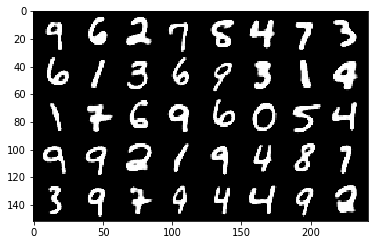

In [66]:
images, labels = dataiter.next()
mu, logvar, pool_1, pool_2 = net.encoder(images.to(device))

# print(mu)
# print(logvar)
# print(pool_1.shape)
# print(pool_2.shape)

print("ACTUAL:")
imshow(torchvision.utils.make_grid(images))

for _ in range(2): 
    z = net.reparametrize(mu, logvar)
    print(z.shape)
    print(z)
    decoded = net.decoder(z).to("cpu").detach()

    print("PREDICTED / GENERATED:") 
    print(decoded.shape)
    imshow2(torchvision.utils.make_grid(decoded))

In [54]:
import torch
import numpy as np

def calc_mu_logvar():
    def sum_2d(x):
        sum = torch.from_numpy(np.zeros(x.shape[1]))
        for i in range(x.shape[1]):
            sum[i] = x[:, i].sum()
        return sum

    color_map = {label: [25 * label, 25 * label, 25 * label] for label in list(range(10))}

    running_mu = torch.from_numpy(np.zeros(50))
    running_logvar = torch.from_numpy(np.zeros(50))

    for i, data in enumerate(trainloader, 0):
        torch.cuda.empty_cache()

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = torch.LongTensor([color_map[l.item()] for l in labels])
        inputs = inputs.to(device)
        batch_size = inputs.shape[0]

        # forward + backward + optimize
        mu, logvar, _, _ = net.encoder(inputs)

        mu = mu.cpu().detach()
        logvar = logvar.cpu().detach()

        running_mu = ((running_mu * i * batch_size) + sum_2d(mu)) / ((i + 1) * batch_size)
        running_logvar = ((running_logvar * i * batch_size) + sum_2d(logvar)) / ((i + 1) * batch_size)

        if i % 500 == 0: 
            print("calculating running mu: {} {} {}".format(i, running_mu, mu))
            
mus_path = "model/mus.pt"
std_dev_path = "model/std_devs.pt"

try: 
    running_mu = torch.load(mus_path)
    running_logvar = torch.load(std_dev_path)
except: 
    calc_mu_logvar()
    torch.save(running_mu, mus_path)
    torch.save(running_logvar, std_dev_path)

        
print("final mu / logvar")
print(running_mu.shape)
print(running_logvar.shape)
print(running_mu)

final mu / logvar
torch.Size([50])
torch.Size([50])
tensor([ 0.0184, -0.0039, -0.0042, -0.0912,  0.0321, -0.0143,  0.0439,  0.0075,
         0.0600, -0.0015,  0.0121, -0.0128, -0.0024, -0.0152,  0.0013, -0.0778,
        -0.0063, -0.0241, -0.0081, -0.0078, -0.0066,  0.0070,  0.0108,  0.0073,
        -0.2045,  0.0120,  0.0010,  0.0071, -0.0255,  0.0019, -0.0358,  0.0043,
        -0.0204,  0.0728,  0.0216,  0.0072,  0.0101, -0.0262,  0.0042,  0.0104,
         0.0184, -0.0058, -0.0310, -0.0174,  0.0053,  0.1326,  0.0267, -0.0103,
         0.0277, -0.0258], dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MEAN digit
torch.Size([40, 1, 28, 28])


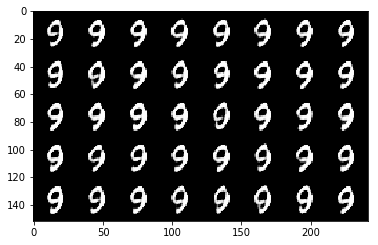

In [55]:

decoded = net.sample(running_mu.type(torch.FloatTensor).repeat(40, 1), 
                     running_logvar.type(torch.FloatTensor).repeat(40, 1), deviation=1)
print("MEAN digit") 
print(decoded.shape)
imshow2(torchvision.utils.make_grid(decoded))
# 40, 1, 28, 28

In [61]:
# discover important variables in the dense representation 
mus_by_abs = [(i, abs(running_mu[i])) for i in list(range(50))]
# reverse=False to only tweak the smallest variables
mus_by_abs = sorted(mus_by_abs, key=lambda p: p[1], reverse=True)
mus_by_abs = [p[0] for p in mus_by_abs]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MEAN digit
torch.Size([40, 1, 28, 28])


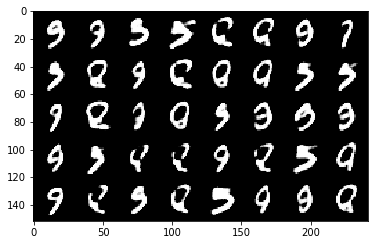

In [66]:
# sample properties using a std deviation of important properties (more deviation for more important properties)
deviation = np.ones(50)
remaining_std_dev = 42 # adjust this to get more or less deviated pictures
for mu in mus_by_abs: 
    deviation[mu] = max(remaining_std_dev / 2, 0)
    remaining_std_dev /= 2
        
deviation = torch.from_numpy(deviation).type(torch.FloatTensor).to(device)

decoded = net.sample(running_mu.type(torch.FloatTensor).repeat(40, 1), 
                     running_logvar.type(torch.FloatTensor).repeat(40, 1), deviation=deviation)
print("MEAN digit") 
print(decoded.shape)
imshow2(torchvision.utils.make_grid(decoded))
# 40, 1, 28, 28